# Проверка гипотез и результатов A/B теста онлайн-магазина

## Описание проекта

**Контекст**
Вместе с отделом маркетинга подготовлен список гипотез для увеличения выручки.
Требуется приоритезировать гипотезы, запустить A/B-тест и проанализировать результаты.

**Часть 1. Приоритизация гипотез**
Задача
Применить фреймворк ICE и RICE для приоритизации гипотез. Отсортировать их по убыванию приоритета.
Указать, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объясните, почему так произошло.

**Часть 2. Анализ A/B-теста**
Проанализировать A/B-тест:
- Построить график кумулятивной выручки по группам. Сделать выводы и вынести предположения.
- Построить график кумулятивного среднего чека по группам. Сделать выводы и вынести предположения.
- Построить график относительного изменения кумулятивного среднего чека группы B к группе A. Сделать выводы и вынести предположения.
- Построить график кумулятивной конверсии по группам. Сделать выводы и вынести предположения.
- Построить график относительного изменения кумулятивной конверсии группы B к группе A. Сделать выводы и вынести предположения.
- Построить точечный график количества заказов по пользователям. Сделать выводы и вынести предположения.
- Посчитать 95-й и 99-й перцентили количества заказов на пользователя. Выбрать границу для определения аномальных пользователей.
- Построить точечный график стоимостей заказов. Сделать выводы и вынести предположения.
- Посчитать 95-й и 99-й перцентили стоимости заказов. Выбрать границу для определения аномальных заказов.
- Посчитать статистическую значимость различий в конверсии между группами по «сырым» данным. Сделать выводы и вынести предположения.
- Посчитать статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделать выводы и вынести предположения.
- Посчитать статистическую значимость различий в конверсии между группами по «очищенным» данным. Сделать выводы и вынести предположения.
- Посчитать статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделать выводы и вынести предположения.
- Принять решение по результатам теста и объяснить его. Варианты решений: 1. Остановить тест, зафиксировать победу одной из групп. 2. Остановить тест, зафиксировать отсутствие различий между группами. 3. Продолжить тест.

## Подготовка данных

In [1]:
import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings
register_matplotlib_converters()

In [2]:
df = pd.read_csv('/datasets/hypothesis.csv')
df.info()
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


In [3]:
#приведем названия столбцов к нижнему регистру

df.columns = df.columns.str.lower()

In [4]:
#проверим, что названия столбцов обновлены корректно, прочитаем строку с описанием гипотезы целиком

with pd.option_context('display.max_colwidth', -1):  
    display(df)

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [5]:
#проверим таблицу на наличие дубликатов

print('Дубликатов в таблице:', df.duplicated().sum())

Дубликатов в таблице: 0


## Часть 1. Приоритизация гипотез 

In [6]:
#посчитаем параметр ICE для гипотез и добавим столбец с ICE к датасету, отсортируем гипотезы по ICE

df['ICE'] = (df['impact'] * df['confidence'])/df['efforts']

display(df[['hypothesis', 'ICE']].sort_values(by = 'ICE', ascending = False))

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день...",16.200000
0,"Добавить два новых канала привлечения трафика,...",13.333333
7,Добавить форму подписки на все основные страни...,11.200000
6,Показать на главной странице баннеры с актуаль...,8.000000
2,Добавить блоки рекомендаций товаров на сайт ин...,7.000000
1,"Запустить собственную службу доставки, что сок...",2.000000
5,"Добавить страницу отзывов клиентов о магазине,...",1.333333
3,"Изменить структура категорий, что увеличит кон...",1.125000
4,"Изменить цвет фона главной страницы, чтобы уве...",1.000000


Топ-5 гипотез (ICE): 
- "Запустить акцию, дающую скидку..." (индекс 8)
- "Добавить два новых канала привлечения..." (индекс 0)
- "Добавить форму подписки..." (индекс 7)
- "Показать на главной странице баннеры..." (индекс 6)
- "Добавить блоки рекомендаций товаров..." (индекс 2)

In [7]:
#посчитаем параметр RICE для гипотез и добавим столбец с RICE к датасету, отсортируем гипотезы по RICE

In [8]:
df['RICE'] = (df['reach'] * df['impact'] * df['confidence'])/df['efforts']

display(df[['hypothesis', 'RICE']].sort_values(by = 'RICE', ascending = False))

,hypothesis,RICE
7,Добавить форму подписки на все основные страни...,112.0
2,Добавить блоки рекомендаций товаров на сайт ин...,56.0
0,"Добавить два новых канала привлечения трафика,...",40.0
6,Показать на главной странице баннеры с актуаль...,40.0
8,"Запустить акцию, дающую скидку на товар в день...",16.2
3,"Изменить структура категорий, что увеличит кон...",9.0
1,"Запустить собственную службу доставки, что сок...",4.0
5,"Добавить страницу отзывов клиентов о магазине,...",4.0
4,"Изменить цвет фона главной страницы, чтобы уве...",3.0


Топ-5 гипотез (RICE): 
- "Добавить форму подписки..." (индекс 7)
- "Добавить блоки рекомендаций товаров..." (индекс 2)
- "Добавить два новых канала привлечения..." (индекс 0)
- "Показать на главной странице баннеры..." (индекс 6)
- "Запустить акцию, дающую скидку..." (индекс 8)

**Вывод**: 
- Гипотеза "Запустить акцию, дающую скидку..." (индекс 8) наиболее перспективна без учета охвата пользователей, но ее вес на порядок ниже (5-е место), когда мы учитываем охват гипотезы. 
- Гипотеза "Добавить форму подписки..." (индекс 7) имеет достаточно сильный вес ICE, но особенно перспективна с точки зрения охвата пользователей. 
- Если компания располагает ресурсами, то все 5 гипотез перспективны, тк топ-5 и ICE, и RICE составляют одни и те же гипотезы.

## Часть 2. Анализ A/B-теста

### Чтение данных и их подготовка

In [9]:
#прочтём данные из файлов с результатами A/B-тестирования 

orders = pd.read_csv('/datasets/orders.csv', sep=',')
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

visitors = pd.read_csv(
    '/datasets/visitors.csv', sep=','
)
visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

print(orders.head())
print(visitors.head()) 

   transactionId   visitorId       date  revenue group
0     3667963787  3312258926 2019-08-15     1650     B
1     2804400009  3642806036 2019-08-15      730     B
2     2961555356  4069496402 2019-08-15      400     A
3     3797467345  1196621759 2019-08-15     9759     B
4     2282983706  2322279887 2019-08-15     2308     B
        date group  visitors
0 2019-08-01     A       719
1 2019-08-02     A       619
2 2019-08-03     A       507
3 2019-08-04     A       717
4 2019-08-05     A       756


In [10]:
#проверим данные на наличие дубликатов

print('Дубликатов в таблице:', orders.duplicated().sum())
print('Дубликатов в таблице:', visitors.duplicated().sum())

Дубликатов в таблице: 0
Дубликатов в таблице: 0


In [11]:
#переименуем названия колонок для их более удобной идентификации

orders.columns = ['orderId','userId','date','revenue','group']

In [12]:
# выберем уникальных пользователей группы А и B с помощью query() и set():

A_users = orders.query('group == "A"')
set_A_users = set(A_users['userId'])

B_users = orders.query('group == "B"')
set_B_users = set(B_users['userId'])

# найдем пересечения множеств с помощью intersection
cross = set_A_users.intersection(set_B_users)

print('Уникальных пользователей в группе A', len(set_A_users))
print('Уникальных пользователей в группе B', len(set_B_users))
print('Попали в обе группы', len(cross))
print('% попавших в обе группы от общего числа', len(cross)/(len(set_A_users)+len(set_B_users))*100)

Уникальных пользователей в группе A 503
Уникальных пользователей в группе B 586
Попали в обе группы 58
% попавших в обе группы от общего числа 5.325987144168963


Вынуждены удалить результаты попавших в обе группы пользователей, так как они оказывают негативный эффект на точность дальнейших расчетов. 

In [13]:
# удалим результаты пользователей + проверим, что пересечений больше нет

orders = orders.query('userId not in @cross') 

A_users = orders.query('group == "A"')
set_A_users = set(A_users['userId'])

B_users = orders.query('group == "B"')
set_B_users = set(B_users['userId'])

# найдем пересечения множеств с помощью intersection
cross = set_A_users.intersection(set_B_users)

print('Попали в обе группы', len(cross))

Попали в обе группы 0


### Графики кумулятивной выручки по дням

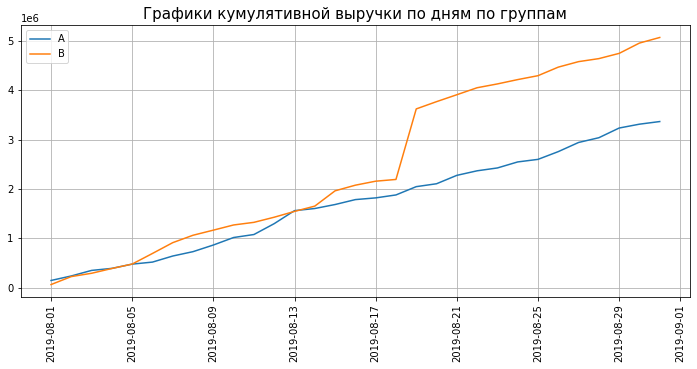

In [14]:
#построим графики кумулятивной выручки по дням по группам

datesGroups = orders[['date', 'group']].drop_duplicates()

ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'orderId': 'nunique',
            'userId': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]

plt.figure(figsize=(12,5))
plt.title('Графики кумулятивной выручки по дням по группам',fontsize=15)
plt.grid(True)
plt.xticks(rotation=90)

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.legend() 

**Вывод**: в середине теста сегмент B имеет резкий подъем. Возможно, это связано с крупными заказами 18-19 августа.

### Графики кумулятивного среднего чека по группам

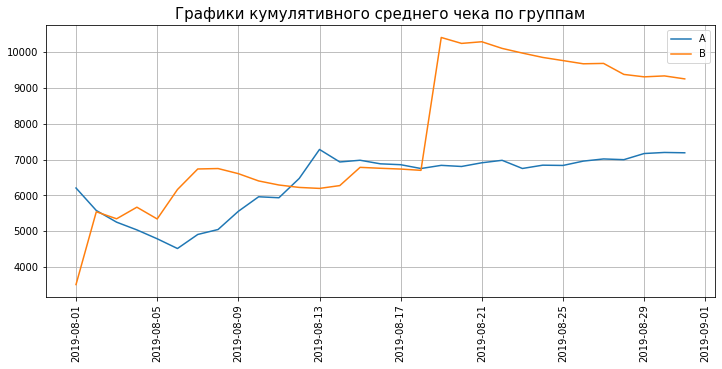

In [15]:
# Построим графики кумулятивного среднего чека по группам

cumulativeRevenueA = cumulativeData[cumulativeData['group'] == 'A'][
    ['date', 'revenue', 'orders']
]
cumulativeRevenueB = cumulativeData[cumulativeData['group'] == 'B'][
    ['date', 'revenue', 'orders']
]


plt.figure(figsize=(12,5))
plt.title('Графики кумулятивного среднего чека по группам',fontsize=15)
plt.grid(True)
plt.xticks(rotation=90)

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend() 

**Вывод**: выброс в сегменте B в ранее озвученный период не дает возможность сделать предварительные выводы по результатам A/B-теста.  

### График относительного изменения кумулятивного среднего чека группы B к группе A

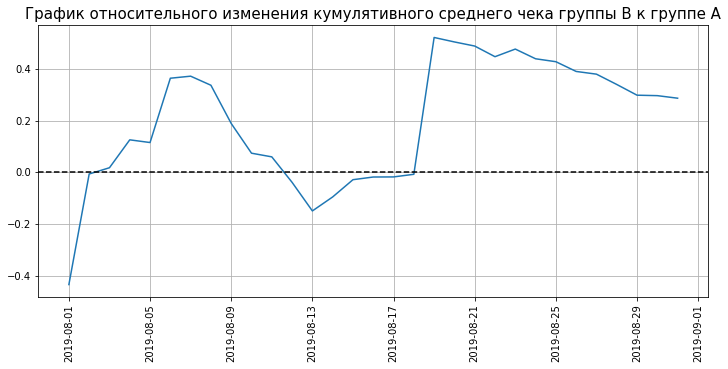

In [16]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(12,5))
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A',fontsize=15)
plt.grid(True)
plt.xticks(rotation=90)

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')

**Вывод**: на графике можно выделить временные интервалы, когда были сделаны большие покупки - 1-3 августа и ранее обозначенные даты - 18-19 августа. 

### График кумулятивной конверсии по группам

(18109.0, 18140.0, 0.0, 0.05)

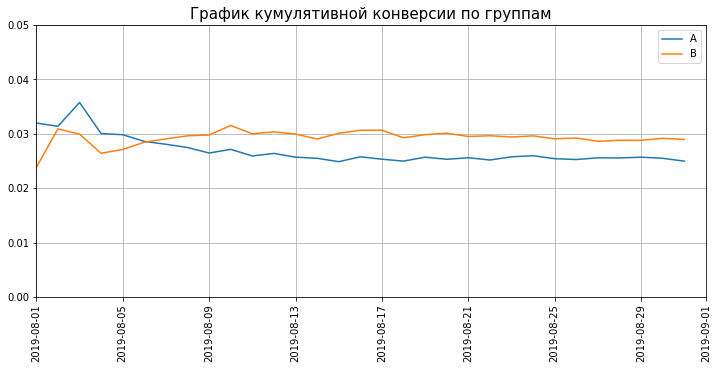

In [17]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики

plt.figure(figsize=(12,5))
plt.title('График кумулятивной конверсии по группам',fontsize=15)
plt.grid(True)
plt.xticks(rotation=90)

plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()

# задаем масштаб осей
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 9, 1), 0, 0.05])

**Вывод**: в начале теста конверсия была примерно равна, но уже с 6 августа конверсия группы B превзошла конверсию группы А, и этот разрыв не менялся до конца проведения теста. 
Колебания конверсии достаточно незначительные, в основном, в коридоре между 3 и 4%. 

### График относительного изменения кумулятивной конверсии группы B к группе A

(18109.0, 18140.0, -0.5, 0.5)

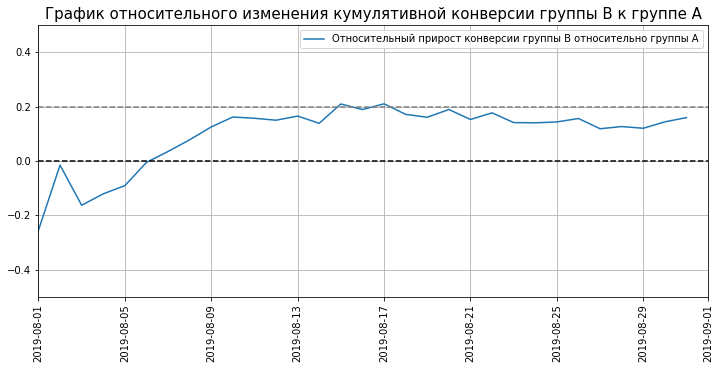

In [18]:
cumulativeData['conversion'] = (
    cumulativeData['orders'] / cumulativeData['visitors']
)

cumulativeDataA = cumulativeData[cumulativeData['group'] == 'A']
cumulativeDataB = cumulativeData[cumulativeData['group'] == 'B']

mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(12,5))
plt.title('График относительного изменения кумулятивной конверсии группы B к группе A',fontsize=15)
plt.grid(True)
plt.xticks(rotation=90)

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')
plt.axis(["2019, 8, 1", '2019, 9, 1', -0.5, 0.5])

**Вывод**: почти с самого начала проведения теста группа B вырывается вперед по конверсии. Прирост составляет около 2%. Но с 18-19 августа прирост конверсии несколько снижается, после чего к концу проведения теста останавливается на примерно 1%.

### Точечный график количества заказов по пользователям

         userId  orders
908  3967698036       3
55    249864742       3
478  2108163459       3
687  2988190573       3
890  3908431265       3
138   611059232       3
632  2742574263       3
157   678354126       2
323  1404560065       2
452  1985475298       2


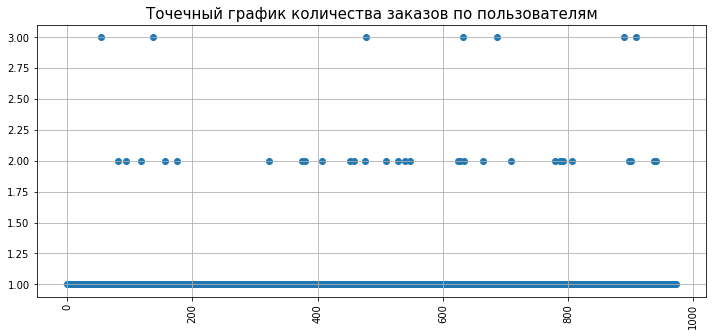

In [19]:
ordersByUsers = (
    orders.groupby('userId', as_index=False)
    .agg({'orderId': 'nunique'})
)
ordersByUsers.columns = ['userId', 'orders']

print(ordersByUsers.sort_values(by='orders', ascending=False).head(10))

# серия из чисел от 0 до количества наблюдений в ordersByUsers
x_values = pd.Series(range(0, len(ordersByUsers)))


plt.figure(figsize=(12,5))
plt.title('Точечный график количества заказов по пользователям',fontsize=15)
plt.grid(True)
plt.xticks(rotation=90)
plt.scatter(x_values, ordersByUsers['orders']) 

**Вывод**: пользователей, сделавших заказ более 2 раз, крайне мало. Они могут быть аномальными. 

### Расчет 95-й и 99-й перцентили количества заказов на пользователя

In [20]:
print(ordersByUsers.sort_values(by='orders', ascending=False).head(10))

print(np.percentile(ordersByUsers['orders'], [95, 99])) 

         userId  orders
908  3967698036       3
55    249864742       3
478  2108163459       3
687  2988190573       3
890  3908431265       3
138   611059232       3
632  2742574263       3
157   678354126       2
323  1404560065       2
452  1985475298       2
[1. 2.]


**Вывод**: не более 5% пользователей совершали покупку более 1 раза, не более 1% - больше 2-х раз.

### Точечный график стоимостей заказов

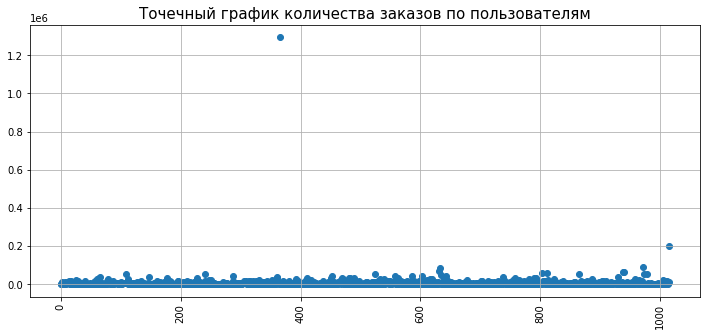

In [21]:
x_values = pd.Series(range(0, len(orders['revenue'])))

plt.figure(figsize=(12,5))
plt.title('Точечный график количества заказов по пользователям',fontsize=15)
plt.grid(True)
plt.xticks(rotation=90)
plt.scatter(x_values, orders['revenue']) 

**Вывод**: сумма большинства заказов - менее 50 тысяч рублей. Распределение стоимости заказов не нормальное. Более точные выводы из графика сделать сложно. Эти значения станут предположительными границами для определения аномалий. Посчитаем перцентили. 

###  95-й и 99-й перцентили стоимости заказов

In [22]:
print(np.percentile(orders['revenue'], [95, 99])) 

[26785. 53904.]


**Вывод**: не более 5% пользователей совершали покупку на сумму 26785 руб, не более 1% - на сумму более 53904 руб.

###  Расчет статистической значимости различий в конверсии между группами по «сырым» данным

In [23]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'orderId', 'userId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'orderId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'orderId', 'userId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'orderId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

display(data.head())

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


Применим критерий и отформатируем p-value. В sampleA сохраним выборку, где каждый элемент — число заказов определённого пользователя. Число элементов sampleA — это количество пользователей, сумма всех элементов — количество заказов. Чтобы получить конверсию в группе, поделим сумму заказов на число пользователей. Аналогично найдём конверсию группы B.
Выведем относительный прирост конверсии группы B: конверсия группы B / конверсия группы A - 1.

За нулевую гипотезу возьмём что: "статистически значимых различий в конверсии между группами нет".
Альтернативная гипотеза - статистически значимые различия есть.

In [24]:
ordersByUsersA = (
    orders[orders['group']=='A']
    .groupby('userId', as_index=False)
    .agg({'orderId' : pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('userId', as_index=False)
    .agg({'orderId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print("alpha =",0.05)
print("p-value = {0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB, alternative = 'two-sided')[1]))
print("Относительный показатель 'B' и 'A' = {0:.3f}".format(sampleB.mean()/sampleA.mean()-1)) 

alpha = 0.05
p-value = 0.011
Относительный показатель 'B' и 'A' = 0.160


**Вывод**: p-value меньше альфа. Есть основания для того, что бы нулевую гипотезу отвергнуть. По «сырым» данным различия в конверсии групп A и B есть. А относительный выигрыш группы B над A равен 16% 

###  Расчет статистической значимости различий в среднем чеке заказа между группами по «сырым» данным

In [25]:
print("alpha =", 0.05)
print("p-value = {0:.3f}".format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'], alternative = 'two-sided')[1]))
print("Относительный показатель 'B' и 'A' = {0:.3f}".format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

alpha = 0.05
p-value = 0.829
Относительный показатель 'B' и 'A' = 0.287


**Вывод:** p-value > 0.05, статистически значимых различий в среднем чеке между группами нет. Можно приступать к анализу аномалий.


*Обратить внимание: наблюдаемое различие 29% не является статзначимым*

###  Расчет статистической значимости различий в конверсии между группами по «очищенным» данны

95-й и 99-й перцентили средних чеков равны 26785 и 53904 рублям. А 95-й и 99-й перцентили количества заказов на одного пользователя равны 1 и 2 заказа на пользователя.


Примем за аномальных пользователей тех, кто совершил >1 заказов или совершил заказ дороже 53904 рублей. Объединим их в таблице abnormalUsers. Узнаем, сколько всего аномальных пользователей методом shape().

In [26]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 1]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 1]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 53904]['userId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print(abnormalUsers.shape[0])

1099    148427295
33      249864742
36      366673373
51      406208401
67      522292794
Name: userId, dtype: int64
45


Всего 45 аномальных пользователей.

Узнаем, как их действия повлияли на результаты теста. Посчитаем статистическую значимость различий в среднем количестве заказов между группами теста по очищенным данным. Сначала подготовим выборки количества заказов по пользователям по группам теста

In [27]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

In [28]:
print("alpha =",0.05)
print("p-value = {0:.3f}".format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered, alternative = 'two-sided')[1]))
print("Относительный показатель 'B' и 'A' = {0:.3f}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

alpha = 0.05
p-value = 0.008
Относительный показатель 'B' и 'A' = 0.188


**Вывод**: p-value = 0.01 меньше 0.05. Есть основания отвергнуть нулевую гипотезу. По очищенным данным различия в конверсии групп A и B так же есть. А относительный выигрыш группы B над A равен 18.9%.

### Расчет статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным

In [29]:
print(
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['userId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['userId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['userId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['userId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

0.969
0.002


**Вывод:** P-value значительно больше 0.05. Аналогично результатам анализа сырых данных: причин отвергать нулевую гипотезу нет. Средний чек группы B оказался на 2% ниже среднего чека группы А, что противоречит результату анализа сырых данных и очевидно означает, что средний чек группы B был настолько высоким (2%) из-за аномально высоких заказов. 

### Принятие решения по результатам теста

**Конверсия**

Относительный выигрыш по результатам анализа сырых данных группы B над A равен 13.8%.
По очищенным данным различия в конверсии групп A и B так же есть. А относительный выигрыш группы B над A равен 17.4%

**Средний чек**

Различия в среднем чеке между группами нет, что стало очевидно после очистки датасета от аномалий.  

**Рекомендовано**

Рекомендовано остановить проведение A/B теста и признать победу группы B (конверсия выше, средний чек примерно равен).